In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import discovery as ds
import json
import numpy as np
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)
import argparse
from functools import partial
import json
import discovery.samplers.numpyro as ds_numpyro
from pathlib import Path
import pickle
import corner
import inspect
import typing
import copy
import random

### Simulation and recovery code for pulsar distance estimates

This notebook, in essence, does the following:
- Simulates pulsar timing residuals assuming user input noise and a user input deteministic continuous wave signal
- Builds a differentiable lnL function that can be used for our experimentation
- Contains basic code to evaluate the lnL at changing pulsar distances in a vectorised form.

#### This code may require a GPU to run

In [3]:
# Set data product directory. The simulation code requires pulsar timing models and data to initialise. 
# In this directory, we have stored these files for a set of pulsars (mimicking the IPTA DR2 dataset, but nonetheless synthetic).

feather_dir = "./data_products/"

#### Simulation code

- This uses the enterprise pulsar timing array modeling software (https://github.com/nanograv/enterprise)
- It works by realizing the signal properties described by the "pta" object using parameter values supplied in the "params" dictionary over Gaussian residual data made from the data products loaded earlier.

In [4]:
from enterprise.signals import signal_base

import numpy as np
import scipy.linalg as sl
import scipy.sparse as ss
from sksparse.cholmod import cholesky
from enterprise.signals import signal_base
from enterprise.signals.gp_signals import get_timing_model_basis, BasisGP
from enterprise.signals.parameter import function
from enterprise_extensions import load_feathers


def simulate(pta, params, sparse_cholesky=True):
    """Simulate code with enterprise (instead of libstempo/PINT)"""
    delays, ndiags, fmats, phis = (pta.get_delay(params=params),
                                   pta.get_ndiag(params=params),
                                   pta.get_basis(params=params),
                                   pta.get_phi(params=params))

    gpresiduals = []
    if pta._commonsignals:
        if sparse_cholesky:
            cf = cholesky(ss.csc_matrix(phis))
            gp = np.zeros(phis.shape[0])
            gp[cf.P()] = np.dot(cf.L().toarray(), np.random.randn(phis.shape[0]))
        else:
            gp = np.dot(sl.cholesky(phis, lower=True), np.random.randn(phis.shape[0]))

        i = 0
        for fmat in fmats:
            j = i + fmat.shape[1]
            gpresiduals.append(np.dot(fmat, gp[i:j]))
            i = j

        assert len(gp) == i
    else:
        for fmat, phi in zip(fmats, phis):
            if phi is None:
                gpresiduals.append(0)
            elif phi.ndim == 1:
                gpresiduals.append(np.dot(fmat, np.sqrt(phi) * np.random.randn(phi.shape[0])))
            else:
                raise NotImplementedError

    whiteresiduals = []
    for delay, ndiag in zip(delays, ndiags):
        if ndiag is None:
            whiteresiduals.append(0)
        elif isinstance(ndiag, signal_base.ShermanMorrison):
            # this code is very slow...
            n = np.diag(ndiag._nvec)
            for j,s in zip(ndiag._jvec, ndiag._slices):
                n[s,s] += j
            whiteresiduals.append(delay + np.dot(sl.cholesky(n, lower=True), np.random.randn(n.shape[0])))
        elif ndiag.ndim == 1:
            whiteresiduals.append(delay + np.sqrt(ndiag) * np.random.randn(ndiag.shape[0]))
        else:
            raise NotImplementedError

    return [np.array(g + w) for g, w in zip(gpresiduals, whiteresiduals)]

def set_residuals(psr, y):
    psr._residuals[psr._isort] = y

@function
def tm_prior(weights, toas, variance=1e40):
    return weights * variance * len(toas)

def TimingModel(coefficients=False, name="linear_timing_model",
                use_svd=False, normed=True, prior_variance=1e40):
    """Class factory for marginalized linear timing model signals."""

    basis = get_timing_model_basis(use_svd, normed)
    prior = tm_prior(variance=prior_variance)

    BaseClass = BasisGP(prior, basis, coefficients=coefficients, name=name)

    class TimingModel(BaseClass):
        signal_type = "basis"
        signal_name = "linear timing model"
        signal_id = name + "_svd" if use_svd else name

    return TimingModel


/home/mattm/miniforge3/envs/discotech/lib/python3.12/site-packages/enterprise/signals/utils.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Requirement, resource_filename


In [5]:
# Load the pulsars data products as Enterprise Pulsar objects
psrs = load_feathers.load_feathers_from_folder(feather_dir)

FeatherPulsar.read_feather: cannot find dmx in feather file ./data_products/B1855+09.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./data_products/B1855+09.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./data_products/B1937+21.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./data_products/B1937+21.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./data_products/B1953+29.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./data_products/B1953+29.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./data_products/J0023+0923.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./data_products/J0023+0923.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./data_products/J0030+0451.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./data_products/J0030+0451.feather.
FeatherPulsar.read_feather: cannot fi

In [6]:
# The _pdist attribute is used by enterprise to store the pulsar distance. Here, we back this up to allow us to vary it later.
for psr in psrs:
    psr._pdist = psr.pdist

### Construct psr signal model (in enterprise)

- The below code block allows us to simulate any signal that we can build a model for in the pulsar data products

Currently, I am only simulating:
- White noise properties in each pulsar.
- Achromatic (radio-frequency independent) time-correlated noise properties in each pulsar.
- A global stochastic background signal (inc. Hellings-Downs correlations) in all pulsars.
- A deterministic continuous wave signal in all pulsars, dependent on the position and distance of the pulsars.
    - This signal does not currently evolve between the Earth and the pulsars, and can be considered monochromatic through time.
    - The evolution will not be difficult to model in, but as the toy model stands this may be the best way to go first.
    - (I do have a suspicion that evolution may actually make it easier to constrain the pulsar distances. But remains to be seen.)


These simulations can be expanded to many, many more signals when we want to make this as realistic as possible.

NB: The stochastic signals are power-law injections. This can be also be edited if we need to.

In [7]:
from enterprise.signals import selections
import enterprise.signals.parameter as parameter
from enterprise.signals import white_signals
from enterprise_extensions.blocks import common_red_noise_block
from enterprise.signals import gp_signals    
from enterprise.signals import utils
from enterprise_extensions import deterministic

tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

selection = selections.Selection(selections.by_backend)
efac = parameter.Constant(1)
equad = parameter.Constant(-8)
# ecorr = parameter.Constant(-8)

log10_A_red = parameter.Uniform(-18, -11)
gamma_red = parameter.Uniform(0, 7)
log10_A_gw = parameter.Uniform(-18,-11)('log10_A_gw')
gamma_gw = parameter.Uniform(0,7)('gamma_gw')

components = 30

tm = TimingModel(coefficients=False, name="linear_timing_model",
                use_svd=False, normed=True, prior_variance=1e-14)
models = []
for p in psrs:
    s = tm

    ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
    s += ef

    eq = white_signals.TNEquadNoise(log10_tnequad=equad, selection=selection)
    s += eq

    # ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr,selection=selection)
    # s += ec

    pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
    rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan, name="rednoise")
    s += rn

    ## HD Correlated signal
    crn = common_red_noise_block(psd='powerlaw', prior='log-uniform',
                        components=components, orf='hd', name='gwb')


    cw = deterministic.cw_block_circ(amp_prior="log-uniform", dist_prior=None, skyloc=None, 
                                     log10_fgw=None, psrTerm=True, discoclone=True, name="cw")
    
    cw2 = deterministic.cw_block_circ(amp_prior="log-uniform", dist_prior=None, skyloc=None, 
                                     log10_fgw=None, psrTerm=True, discoclone=True, name="cw2")

    s += crn
    s += cw 

    s += cw2

    models.append(s(p))
    print(p.name)
pta = signal_base.PTA(models)

pta.set_default_params({})

B1855+09
B1937+21
B1953+29
J0023+0923
J0030+0451
J0125-2327
J0340+4130
J0406+3039
J0437-4715
J0509+0856
J0557+1551
J0605+3757
J0610-2100
J0613-0200
J0614-3329
J0636+5128
J0636-3044
J0645+5158
J0709+0458
J0711-6830
J0740+6620
J0751+1807
J0900-3144
J0931-1902
J0955-6150
J1012+5307
J1012-4235
J1017-7156
J1022+1001
J1024-0719
J1036-8317
J1045-4509
J1101-6424
J1103-5403
J1125+7819
J1125-5825
J1125-6014
J1216-6410
J1312+0051
J1327-0755
J1421-4409
J1431-5740
J1435-6100
J1446-4701
J1453+1902
J1455-3330
J1525-5545
J1543-5149
J1545-4550
J1547-5709
J1600-3053
J1603-7202
J1614-2230
J1629-6902
J1630+3734
J1640+2224
J1643-1224
J1652-4838
J1653-2054
J1658-5324
J1705-1903
J1708-3506
J1713+0747
J1719-1438
J1721-2457
J1730-2304
J1732-5049
J1737-0811
J1738+0333
J1741+1351
J1744-1134
J1745+1017
J1747-4036
J1751-2857
J1756-2251
J1757-5322
J1801-1417
J1802-2124
J1804-2717
J1811-2405
J1824-2452A
J1825-0319
J1832-0836
J1843-1113
J1853+1303
J1902-5105
J1903+0327
J1903-7051
J1909-3744
J1910+1256
J1911+1347
J191

Duplicate signal B1855+09_cw from objects <Enterprise Signal object cw[cw2_log10_h0, cw2_log10_f0, cw2_ra, cw2_sindec, cw2_cosinc, cw2_psi, cw2_phi_earth, B1855+09_cw_p_dist]> and <Enterprise Signal object cw[cw_log10_h0, cw_log10_f0, cw_ra, cw_sindec, cw_cosinc, cw_psi, cw_phi_earth, B1855+09_cw_p_dist]>.
This functionality was added in v1.1.0 and may cause post v1.1.0 functionality to break.
This may not cause other errors but it is recommended that you use a custom name for one of the duplicate signals.

Duplicate signal B1937+21_cw from objects <Enterprise Signal object cw[cw2_log10_h0, cw2_log10_f0, cw2_ra, cw2_sindec, cw2_cosinc, cw2_psi, cw2_phi_earth, B1937+21_cw_p_dist]> and <Enterprise Signal object cw[cw_log10_h0, cw_log10_f0, cw_ra, cw_sindec, cw_cosinc, cw_psi, cw_phi_earth, B1937+21_cw_p_dist]>.
This functionality was added in v1.1.0 and may cause post v1.1.0 functionality to break.
This may not cause other errors but it is recommended that you use a custom name for one o

In [8]:
# Print out a summary of what's being modelled in the PTA.

print(pta.summary())

enterprise v3.4.4,  Python v3.12.11

Signal Name                              Signal Class                   no. Parameters      
B1855+09_linear_timing_model             TimingModel                    0                   

params:
__________________________________________________________________________________________
B1855+09_measurement_noise               MeasurementNoise               0                   

params:
B1855+09_KAT_MKBF_efac:Constant=1                                                         
__________________________________________________________________________________________
B1855+09_tnequad                         TNEquadNoise                   0                   

params:
B1855+09_KAT_MKBF_log10_tnequad:Constant=-8                                               
__________________________________________________________________________________________
B1855+09_rednoise                        FourierBasisGP                 2                   

Basis shape (Nt

#### Parameter value selection

To define the parameters we want to simulate, it's easiest just to load in a dictionary describing them.

- I'm including random value achromatic red noise from a "realistic" distribution. Currently it is extremely weak and undetectable (between -18 and -17) so that the rest can be tested. (tag: rednoise)
- The pulsar distances are being injected at their logged values that have been manually set. (tag: _cw_p_dist)
- The stochastic background is injected at a theoretical spectral index, but incredibly weakly (tag: gw)
- The deterministic continuous wave signal is being injected at the bottom of the cell (tag: cw)


For clarity, descriptions of the continuous wave parameters are:
- cw_cosinc: cosine of Inclination of GW source (radians)
- cw_log10_f0: log10 of frequency of signal 
- cw_log10_h0: log10 of GW strain
- cw_phi_earth: phase of signal at Earth
- cw_psi: Polarisation angle of GW source
- cw_ra: RA of CW source
- cw_sindec: sin(declination) of CW source

In [9]:
enterprise_params ={}
enterprise_params.update({p: np.random.uniform(-18,-15) for p in pta.param_names if 'rednoise_log10_A' in p})
enterprise_params.update({p: np.random.uniform(3,4) for p in pta.param_names if 'rednoise_gamma' in p})

for psr in psrs:
    enterprise_params.update({p: psr.pdist[0] for p in pta.param_names if psr.name+'_cw_p_dist' in p})

enterprise_params.update({'gw_gamma': 4.333, 'gw_log10_A': -14.5})
enterprise_params.update({'cw_cosinc': 0, 'cw_log10_f0': -8, 'cw_log10_h0': -13, 'cw_phi_earth':np.pi, 'cw_psi': np.pi/4.0, 'cw_ra': 0.458, 'cw_sindec': 0.43})
# second det source
enterprise_params.update({'cw2_cosinc': 0, 'cw2_log10_f0': -7.5, 'cw2_log10_h0': -13, 'cw2_phi_earth':np.pi, 'cw2_psi': np.pi/4.0, 'cw2_ra': 0.158, 'cw2_sindec': 0.13})

In [10]:
dec1, dec2 = np.arcsin(enterprise_params['cw_sindec']), np.arcsin(enterprise_params['cw2_sindec'])
ra1, ra2 = enterprise_params['cw_ra'], enterprise_params['cw2_ra']
ang_sep = np.arccos(np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2))

In [11]:
ang_sep*180/np.pi   

np.float64(24.344115911458157)

In [12]:
enterprise_params

{'B1855+09_rednoise_log10_A': -15.143539424306832,
 'B1937+21_rednoise_log10_A': -17.70345681507809,
 'B1953+29_rednoise_log10_A': -15.461317057193032,
 'J0023+0923_rednoise_log10_A': -16.909794634042857,
 'J0030+0451_rednoise_log10_A': -16.526207832736453,
 'J0125-2327_rednoise_log10_A': -16.759057047952375,
 'J0340+4130_rednoise_log10_A': -17.625835873328967,
 'J0406+3039_rednoise_log10_A': -16.731689201861684,
 'J0437-4715_rednoise_log10_A': -15.704395138439242,
 'J0509+0856_rednoise_log10_A': -16.435300246080466,
 'J0557+1551_rednoise_log10_A': -16.291777228479194,
 'J0605+3757_rednoise_log10_A': -16.74190585262586,
 'J0610-2100_rednoise_log10_A': -15.981171465035947,
 'J0613-0200_rednoise_log10_A': -15.952478195119632,
 'J0614-3329_rednoise_log10_A': -16.432773858424184,
 'J0636+5128_rednoise_log10_A': -17.88183512914164,
 'J0636-3044_rednoise_log10_A': -17.074917868081425,
 'J0645+5158_rednoise_log10_A': -16.349234478183803,
 'J0709+0458_rednoise_log10_A': -17.81222816895916,
 'J

In [13]:
# Based on the above parameters, simulate the new timing residuals

res = simulate(pta, enterprise_params, sparse_cholesky=True)

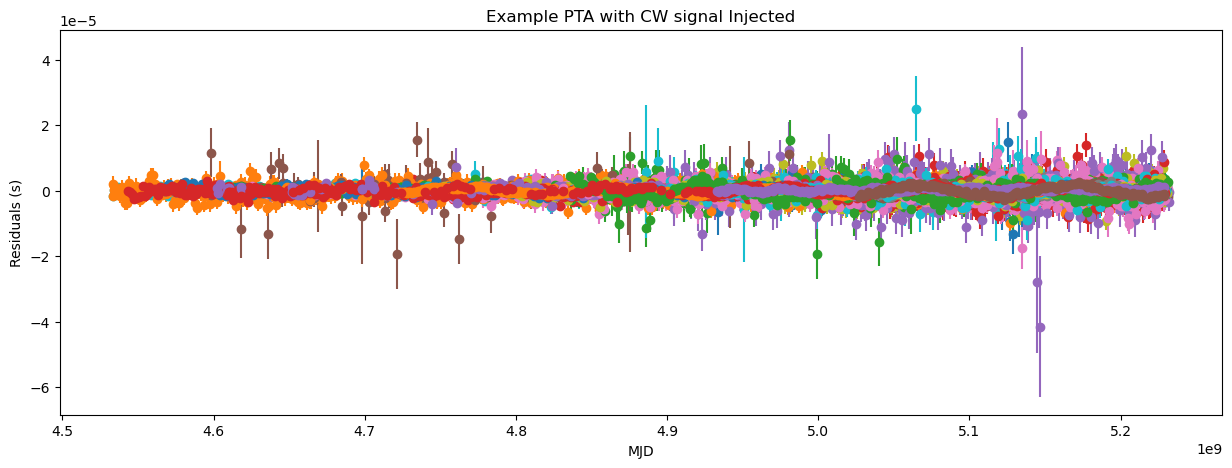

In [14]:
# Check Enterprise simulated residuals
plt.figure(figsize=(15,5))
for i, res_i in enumerate(res):
    plt.errorbar(psrs[i].toas, res_i, yerr=psrs[i].toaerrs, fmt='o')
    plt.xlabel('MJD')   
    plt.ylabel('Residuals (s)')
    plt.title("Example PTA with CW signal Injected")

##### Now set up differentiable likelihood

- First, we want to reload the original data products into the discovery software (https://github.com/nanograv/discovery/tree/main) so that an original data object can be created.
- Then, overwrite the discovery pulsar residuals with the simulated residuals we created above

In [15]:
disco_psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(feather_dir+'*.feather'))] 

In [16]:
for i, dpsr in enumerate(disco_psrs):
    dpsr.residuals = np.array(res[i])

I am arbitrarily decreasing the level of white noise in the residuals for now. I want a relatively noiseless signal.

In [17]:
for dpsr in disco_psrs:
    wn_level = 1e-6
    dpsr.toaerrs = np.array(len(dpsr.toas) *[wn_level])

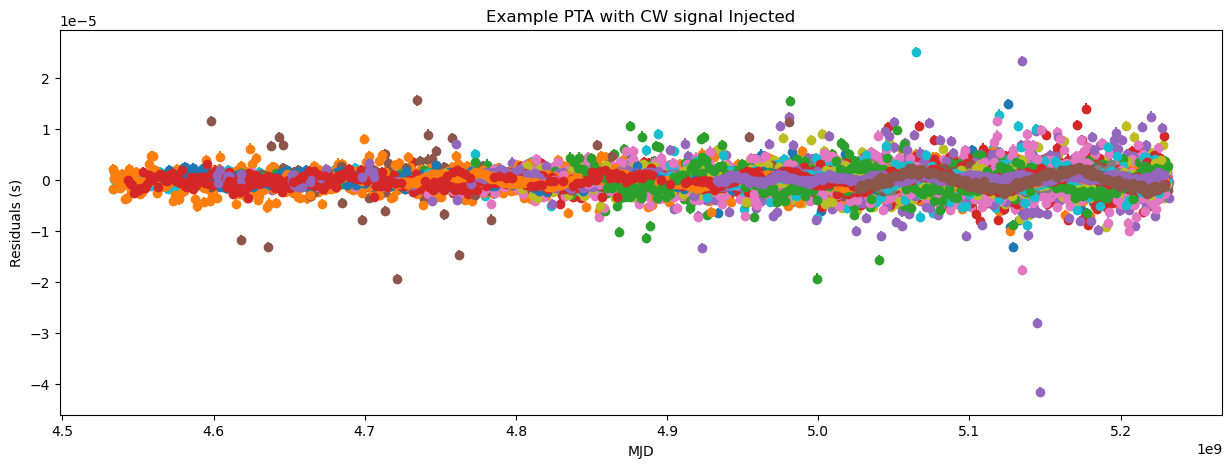

In [18]:
#Check the new data that the signal is consistent with the previous plot

plt.figure(figsize=(15,5))
for i, dpsr in enumerate(disco_psrs):
    plt.errorbar(dpsr.toas, dpsr.residuals, yerr=dpsr.toaerrs, fmt='o')
    plt.xlabel('MJD')   
    plt.ylabel('Residuals (s)')
    plt.title("Example PTA with CW signal Injected")

#### Set up signal model for continuous wave for use in differentiable lnL

This is a simple model that includes a dependence on pulsar distances. This model has no evolution yet, but that will change.

In [19]:
# Custom function to use the p_dist rather than p_phase


def fpc_fast(pos, gwtheta, gwphi):
    x, y, z = pos

    sin_phi = jnp.sin(gwphi)
    cos_phi = jnp.cos(gwphi)
    sin_theta = jnp.sin(gwtheta)
    cos_theta = jnp.cos(gwtheta)

    m_dot_pos = sin_phi * x - cos_phi * y
    n_dot_pos = -cos_theta * cos_phi * x - cos_theta * sin_phi * y + sin_theta * z
    omhat_dot_pos = -sin_theta * cos_phi * x - sin_theta * sin_phi * y - cos_theta * z

    denom = 1.0 + omhat_dot_pos

    fplus = 0.5 * (m_dot_pos**2 - n_dot_pos**2) / denom
    fcross = (m_dot_pos * n_dot_pos) / denom

    return fplus, fcross
    
def cos2comp(f, df, A, f0, phi, t0):
    """Project signal A * cos(2pi f t + phi) onto Fourier basis
    cos(2pi k t/T), sin(2pi k t/T) for t in [t0, t0+T]."""

    T = 1.0 / df[0]

    Delta_omega = 2.0 * jnp.pi * (f0 - f[::2])
    Sigma_omega = 2.0 * jnp.pi * (f0 + f[::2])

    phase_Delta_start = phi + Delta_omega * t0
    phase_Delta_end   = phi + Delta_omega * (t0 + T)

    phase_Sigma_start = phi + Sigma_omega * t0
    phase_Sigma_end   = phi + Sigma_omega * (t0 + T)

    ck = (A / T) * (
        (jnp.sin(phase_Delta_end) - jnp.sin(phase_Delta_start)) / Delta_omega +
        (jnp.sin(phase_Sigma_end) - jnp.sin(phase_Sigma_start)) / Sigma_omega
    )

    sk = (A / T) * (
        (jnp.cos(phase_Delta_end) - jnp.cos(phase_Delta_start)) / Delta_omega -
        (jnp.cos(phase_Sigma_end) - jnp.cos(phase_Sigma_start)) / Sigma_omega
    )

    return jnp.stack((sk, ck), axis=1).reshape(-1)



def makefourier_binary_pdist(pulsarterm=True):
    def fourier_binary_pdist(f, df, mintoa, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, p_dist):
        h0 = 10**log10_h0
        f0 = 10**log10_f0

        pos = jnp.array(pos)
        
        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

        # calculate antenna pattern
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)

        c = 2.99792458e8 
        omega_hat = jnp.array([ -jnp.cos(dec) * jnp.cos(ra), 
                                -jnp.cos(dec) * jnp.sin(ra),
                                -jnp.sin(dec)
                              ])

        # Convert pulsar distance from kpc to meters to match c [m/s]
        p_dist_m = p_dist * 3.0856775814913673e19  # 1 kpc in meters
        phi_psr = (p_dist_m / c) * 2.0 * jnp.pi * f0  * (1.0 + jnp.dot(omega_hat, pos))

        if pulsarterm:
            phi_avg = 0.5 * (phi_earth + phi_psr)
        else:
            phi_avg = phi_earth

        tref = 86400.0 * 51544.5  # MJD J2000 in seconds

        cphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref, mintoa)
        sphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref - 0.5 * jnp.pi, mintoa)

        if pulsarterm:
            phi_diff = 0.5 * (phi_earth - phi_psr)
            sin_diff = jnp.sin(phi_diff)

            delta_sin =  2.0 * cphase * sin_diff
            delta_cos = -2.0 * sphase * sin_diff
        else:
            delta_sin = sphase
            delta_cos = cphase

        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt =  2.0 * jnp.cos(inc) * delta_cos

        alpha = h0 / (2 * jnp.pi * f0)

        rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

        res = -fplus * rplus - fcross * rcross

        return res

    if not pulsarterm:
        fourier_binary_pdist = functools.partial(fourier_binary, p_dist=jnp.nan)

    return fourier_binary_pdist

In [20]:
def makefourier_binary_pdist_twoD(pulsarterm=True):
    def fourier_binary_pdist_twoD(f, df, mintoa, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, 
                             log10_h0_2, log10_f0_2, ra_2, sindec_2, cosinc_2, psi_2, phi_earth_2, p_dist):
        
        h0 = 10**log10_h0
        f0 = 10**log10_f0

        h0_2 = 10**log10_h0_2
        f0_2 = 10**log10_f0_2

        pos = jnp.array(pos)
        
        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)
        dec_2, inc_2 = jnp.arcsin(sindec_2), jnp.arccos(cosinc_2)

        # calculate antenna pattern
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)
        fplus_2, fcross_2 = fpc_fast(pos, 0.5 * jnp.pi - dec_2, ra_2)

        c = 2.99792458e8 
        omega_hat = jnp.array([ -jnp.cos(dec) * jnp.cos(ra), 
                                -jnp.cos(dec) * jnp.sin(ra),
                                -jnp.sin(dec)
                              ])
        omega_hat_2 = jnp.array([ -jnp.cos(dec_2) * jnp.cos(ra_2), 
                                -jnp.cos(dec_2) * jnp.sin(ra_2),
                                -jnp.sin(dec_2)
                              ])

        # Convert pulsar distance from kpc to meters to match c [m/s]
        p_dist_m = p_dist * 3.0856775814913673e19  # 1 kpc in meters
        phi_psr = (p_dist_m / c) * 2.0 * jnp.pi * f0  * (1.0 + jnp.dot(omega_hat, pos))

        phi_psr_2 = (p_dist_m / c) * 2.0 * jnp.pi * f0_2  * (1.0 + jnp.dot(omega_hat_2, pos))


        if pulsarterm:
            phi_avg = 0.5 * (phi_earth + phi_psr)
            phi_avg_2 = 0.5 * (phi_earth_2 + phi_psr_2)
        else:
            phi_avg = phi_earth
            phi_avg_2 = phi_earth_2

        tref = 86400.0 * 51544.5  # MJD J2000 in seconds

        cphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref, mintoa)
        sphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref - 0.5 * jnp.pi, mintoa)

        cphase_2 = cos2comp(f, df, 1.0, f0_2, phi_avg_2 - 2.0 * jnp.pi * f0_2 * tref, mintoa)
        sphase_2 = cos2comp(f, df, 1.0, f0_2, phi_avg_2 - 2.0 * jnp.pi * f0_2 * tref - 0.5 * jnp.pi, mintoa)

        if pulsarterm:
            phi_diff = 0.5 * (phi_earth - phi_psr)
            sin_diff = jnp.sin(phi_diff)

            delta_sin =  2.0 * cphase * sin_diff
            delta_cos = -2.0 * sphase * sin_diff

            phi_diff_2 = 0.5 * (phi_earth_2 - phi_psr_2)
            sin_diff_2 = jnp.sin(phi_diff_2)

            delta_sin_2 =  2.0 * cphase_2 * sin_diff_2
            delta_cos_2 = -2.0 * sphase_2 * sin_diff_2
        else:
            delta_sin = sphase
            delta_cos = cphase

        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt =  2.0 * jnp.cos(inc) * delta_cos

        At_2 = -1.0 * (1.0 + jnp.cos(inc_2)**2) * delta_sin_2
        Bt_2 =  2.0 * jnp.cos(inc_2) * delta_cos_2

        alpha = h0 / (2 * jnp.pi * f0)

        alpha_2 = h0_2 / (2 * jnp.pi * f0_2)

        rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))


        rplus_2  = alpha_2 * (-At_2 * jnp.cos(2 * psi_2) + Bt_2 * jnp.sin(2 * psi_2))
        rcross_2 = alpha_2 * ( At_2 * jnp.sin(2 * psi_2) + Bt_2 * jnp.cos(2 * psi_2))

        res = -fplus * rplus - fcross * rcross
        res2 = -fplus_2 * rplus_2 - fcross_2 * rcross_2

        return res + res2

    if not pulsarterm:
        fourier_binary_pdist_twoD = functools.partial(fourier_binary, p_dist=jnp.nan)

    return fourier_binary_pdist_twoD

In [21]:
# For testing purposes, only use 10 pulsars

disco_psrs = disco_psrs[:10]

In [22]:
# This dictionary just fixes the white noise parameters to what was input in the model above.

noisedict = {}
for dpsr in disco_psrs:
    noisedict[dpsr.name+"_KAT_MKBF_efac"] = 1 # EFAC=1 means no EFAC
    noisedict[dpsr.name+"_KAT_MKBF_log10_ecorr"] = -8 # Bringing these down to effectively 0
    noisedict[dpsr.name+"_KAT_MKBF_log10_t2equad"] = -8

Below is the likelihood model of a pulsar timing array with intrinsic achromatic red noise, an uncorrelated stochastic background signal, and a deterministic continous wave signal.

NB: This modelling code is extremely useful, but is also extremely in development. Because of this, we are slightly limited by what can be done to the model. But there a suitable number of trinks we can employ to get around most issues.

In [23]:
# Fourier based CW delay
fourdelay = makefourier_binary_pdist(pulsarterm=True)
cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']

T = ds.getspan(disco_psrs)
fml = ds.ArrayLikelihood([ds.PulsarLikelihood([dpsr.residuals,
                                               ds.makenoise_measurement(dpsr, noisedict=noisedict),
                                               ds.makegp_timing(dpsr, variance=1e-14),
                                               ]) for dpsr in disco_psrs],

                          commongp = ds.makecommongp_fourier(disco_psrs, ds.powerlaw, 30, T, name='rednoise'),
                          globalgp = ds.makeglobalgp_fourier(disco_psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T, means=fourdelay, common=cwcommon, name='gw', meansname='cw'))

In [24]:
# Fourier based CW delay
fourdelay = makefourier_binary_pdist_twoD(pulsarterm=True)
cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra', 'cw_sindec_2', 'cw_cosinc_2', 'cw_log10_f0_2', 'cw_log10_h0_2', 'cw_phi_earth_2', 'cw_psi_2', 'cw_ra_2']

T = ds.getspan(disco_psrs)
fml2 = ds.ArrayLikelihood([ds.PulsarLikelihood([dpsr.residuals,
                                               ds.makenoise_measurement(dpsr, noisedict=noisedict),
                                               ds.makegp_timing(dpsr, variance=1e-14),
                                               ]) for dpsr in disco_psrs],

                          commongp = ds.makecommongp_fourier(disco_psrs, ds.powerlaw, 30, T, name='rednoise'),
                          globalgp = ds.makeglobalgp_fourier(disco_psrs, ds.powerlaw, ds.hd_orf, 30, T, means=fourdelay, common=cwcommon, name='gw', meansname='cw'))

In [25]:
# The prior dictionary needs to be updated to include the pulsar distance priors for each pulsar.
ds.prior.priordict_standard.update({
    '(.*_)?cw_p_dist':     [0.1, 5]
})

In [26]:
ds.prior.priordict_standard

{'(.*_)?efac': [0.9, 1.1],
 '(.*_)?t2equad': [-8.5, -5],
 '(.*_)?tnequad': [-8.5, -5],
 '(.*_)?log10_ecorr': [-8.5, -5],
 '(.*_)?rednoise_log10_A.*': [-20, -11],
 '(.*_)?rednoise_gamma.*': [0, 7],
 '(.*_)?rednoise_log10_fb': [-9, -6],
 '(.*_)?red_noise_log10_A.*': [-20, -11],
 '(.*_)?red_noise_gamma.*': [0, 7],
 '(.*_)?red_noise_log10_fb': [-9, -6],
 'crn_log10_A.*': [-18, -11],
 'crn_gamma.*': [0, 7],
 'crn_log10_fb': [-9, -6],
 'gw_(.*_)?log10_A': [-18, -11],
 'gw_(.*_)?gamma': [0, 7],
 'gw_log10_fb': [-9, -6],
 '(.*_)?dmgp_log10_A': [-20, -11],
 '(.*_)?dmgp_gamma': [0, 7],
 '(.*_)?dmgp_alpha': [1, 3],
 '(.*_)?chromgp_log10_A': [-20, -11],
 '(.*_)?chromgp_gamma': [0, 7],
 '(.*_)?chromgp_alpha': [1, 7],
 '(.*_)?dm_gp_log10_A': [-20, -11],
 '(.*_)?dm_gp_gamma': [0, 7],
 '(.*_)?dm_gp_alpha': [1, 3],
 '(.*_)?chrom_gp_log10_A': [-20, -11],
 '(.*_)?chrom_gp_gamma': [0, 7],
 '(.*_)?chrom_gp_alpha': [1, 3],
 'crn_log10_rho': [-9, -4],
 'gw_(.*_)?log10_rho': [-9, -4],
 '(.*_)?red_noise_log10_

In [27]:
# Check that the pulsars have distances associate with them

for dpsr in disco_psrs:
    print(dpsr.pdist)

[1.18, 0.12]
[3.1, 0.2]
[4.64, 0.93]
[1.02, 0.11]
[0.3296, 0.0036]
[0.873, 0.1746]
[1.71, 0.34]
[1.72, 0.34]
[0.1549, 0.001]
[1.45, 0.29]


In [28]:
# To list the parameters in the likelihood model:

fml2.logL.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_cosinc_2',
 'cw_log10_f0',
 'cw_log10_f0_2',
 'cw_log10_h0',
 'cw_log10_h0_2',
 'cw_phi_earth',
 'cw_phi_earth_2',
 'cw_psi',
 'c

In [29]:
# Setting the lnL 

logl = fml2.logL

In [30]:

temp_dict = enterprise_params.copy()

In [31]:
for key in enterprise_params.keys():
    if 'cw2' in key:
        newkey = key.replace('cw2', 'cw')
        newkey = newkey+"_2"
        temp_dict[newkey] = enterprise_params[key]
        del temp_dict[key]


In [32]:
temp_dict

{'B1855+09_rednoise_log10_A': -15.143539424306832,
 'B1937+21_rednoise_log10_A': -17.70345681507809,
 'B1953+29_rednoise_log10_A': -15.461317057193032,
 'J0023+0923_rednoise_log10_A': -16.909794634042857,
 'J0030+0451_rednoise_log10_A': -16.526207832736453,
 'J0125-2327_rednoise_log10_A': -16.759057047952375,
 'J0340+4130_rednoise_log10_A': -17.625835873328967,
 'J0406+3039_rednoise_log10_A': -16.731689201861684,
 'J0437-4715_rednoise_log10_A': -15.704395138439242,
 'J0509+0856_rednoise_log10_A': -16.435300246080466,
 'J0557+1551_rednoise_log10_A': -16.291777228479194,
 'J0605+3757_rednoise_log10_A': -16.74190585262586,
 'J0610-2100_rednoise_log10_A': -15.981171465035947,
 'J0613-0200_rednoise_log10_A': -15.952478195119632,
 'J0614-3329_rednoise_log10_A': -16.432773858424184,
 'J0636+5128_rednoise_log10_A': -17.88183512914164,
 'J0636-3044_rednoise_log10_A': -17.074917868081425,
 'J0645+5158_rednoise_log10_A': -16.349234478183803,
 'J0709+0458_rednoise_log10_A': -17.81222816895916,
 'J

In [33]:
#Need to sort dict so it remains in the same order as the logl.params (paranoia is healthy)
order_map = {key: i for i, key in enumerate(logl.params)}

sorted_items = sorted(temp_dict.items(), key=lambda item: order_map.get(item[0], float('inf')))
sorted_dict = dict(sorted_items)

In [34]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 3.9972421032492766,
 'B1855+09_rednoise_log10_A': -15.143539424306832,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 3.823519054387763,
 'B1937+21_rednoise_log10_A': -17.70345681507809,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 3.7315610081024646,
 'B1953+29_rednoise_log10_A': -15.461317057193032,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 3.0082020673754766,
 'J0023+0923_rednoise_log10_A': -16.909794634042857,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 3.179036012369634,
 'J0030+0451_rednoise_log10_A': -16.526207832736453,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 3.7775498336479956,
 'J0125-2327_rednoise_log10_A': -16.759057047952375,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 3.440711894868166,
 'J0340+4130_rednoise_log10_A': -17.625835873328967,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 3.468066388291829,
 '

In [35]:
logl.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_cosinc_2',
 'cw_log10_f0',
 'cw_log10_f0_2',
 'cw_log10_h0',
 'cw_log10_h0_2',
 'cw_phi_earth',
 'cw_phi_earth_2',
 'cw_psi',
 'c

Slightly unresolved jit issue means that I have to use this wrapper below as a workaround to get the lnL to quickly evaluate

In [36]:

param_keys = list(sorted_dict.keys())

# Define the wrapper
def logl_wrapped(x_array):
    # Convert array -> dict
    params = {k: v for k, v in zip(param_keys, x_array)}
    return logl(params)

In [37]:
param_keys

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_cosinc_2',
 'cw_log10_f0',
 'cw_log10_f0_2',
 'cw_log10_h0',
 'cw_log10_h0_2',
 'cw_phi_earth',
 'cw_phi_earth_2',
 'cw_psi',
 'c

jit and test the likelihood against the unjitted version

In [38]:
logl_fn = jax.jit(logl_wrapped)

In [39]:
# Jitted
x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
logl_fn(x0)

Array(37415.87325293, dtype=float64)

In [ ]:
#Unjitted
logl(sorted_dict)

Array(37569.42102649, dtype=float64)

: 

: 

: 

#### pulsar distance testing

Here I'm iterating around the pulsar distances for 3 of the 10 puslars in the array.

All other parameters sit at their true (injected) values and then I'm just shaking the values of the three pular distances below

In [ ]:
print(enterprise_params['J0437-4715_cw_p_dist'])
print(enterprise_params['J0030+0451_cw_p_dist'])
print(enterprise_params['J0125-2327_cw_p_dist'])

0.1549
0.3296
0.873


: 

: 

In [ ]:
from tqdm import tqdm

distance1 = np.linspace(0.01, 5, 50)
distance2 = np.linspace(0.01, 1, 100)
distance3 = np.linspace(0.01, 5, 50)
logls = []
temp_dict = sorted_dict.copy()

order_map = {key: i for i, key in enumerate(logl.params)}

sorted_items = sorted(temp_dict.items(), key=lambda item: order_map.get(item[0], float('inf')))
sorted_dict = dict(sorted_items)

# for d1 in tqdm(distance1, desc="Distance 1 Loop"):
#     sorted_dict['J0437-4715_cw_p_dist'] = d1
for d2 in distance2:
    sorted_dict['J0030+0451_cw_p_dist'] = d2
    x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
    logls.append(logl_fn(x0))
        # for d3 in distance3:
        #     sorted_dict['J0125-2327_cw_p_dist'] = d3
            # x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
            # logls.append(logl_fn(x0))
            #logls.append(logl(temp_dict))

    

In [42]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 3.9972421032492766,
 'B1855+09_rednoise_log10_A': -15.143539424306832,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 3.823519054387763,
 'B1937+21_rednoise_log10_A': -17.70345681507809,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 3.7315610081024646,
 'B1953+29_rednoise_log10_A': -15.461317057193032,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 3.0082020673754766,
 'J0023+0923_rednoise_log10_A': -16.909794634042857,
 'J0030+0451_cw_p_dist': np.float64(1.0),
 'J0030+0451_rednoise_gamma': 3.179036012369634,
 'J0030+0451_rednoise_log10_A': -16.526207832736453,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 3.7775498336479956,
 'J0125-2327_rednoise_log10_A': -16.759057047952375,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 3.440711894868166,
 'J0340+4130_rednoise_log10_A': -17.625835873328967,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 3.4680663882

In [43]:
logl_fn(x0)

Array(36703.85415343, dtype=float64)

(37300.0, 37500.0)

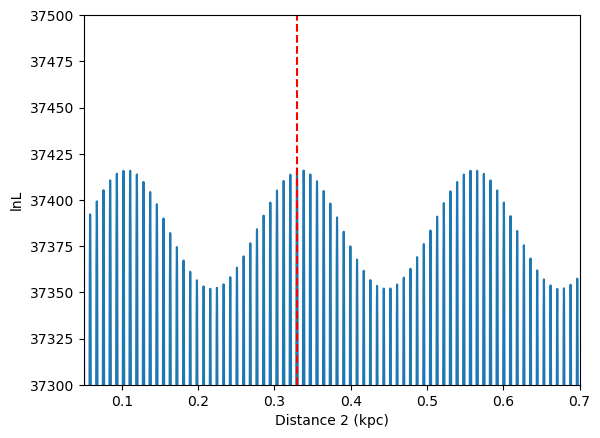

In [46]:
plt.plot(distance2,logls)
plt.ylabel("lnL")
plt.xlabel("Distance 2 (kpc)")
plt.axvline(enterprise_params['J0030+0451_cw_p_dist'], color='r', linestyle='--', label='Injected Distance')
plt.xlim(0.05, 0.7)
plt.ylim(37300, 37500)

In [47]:
# Normal for loop was taking ages. Attempt at vectorization.

# Alter gridsteps to change the coarseness of the grid. 
# The distances are surrounding the true values to understand the oscillations

from tqdm import tqdm

gridsteps = 100

distance1 = jnp.linspace(0.01, 0.2, gridsteps)
distance2 = jnp.linspace(0.25, 0.4, gridsteps)
distance3 = jnp.linspace(0.8, 1, gridsteps)

# Precompute everything that’s constant
order_map = {key: i for i, key in enumerate(logl.params)}
sorted_items = sorted(temp_dict.items(), key=lambda item: order_map.get(item[0], float('inf')))
base_params = jnp.array(list(dict(sorted_items).values()), dtype=jnp.float64)

# Get indices of the 3 pulsar-distance parameters in the array
i1 = order_map['J0437-4715_cw_p_dist']
i2 = order_map['J0030+0451_cw_p_dist']
i3 = order_map['J0125-2327_cw_p_dist']

# Make a full 3D meshgrid of parameter values
D1, D2, D3 = jnp.meshgrid(distance1, distance2, distance3, indexing='ij')
npts = D1.size*2

# Flatten for vectorized evaluation
D1f, D2f, D3f = D1.ravel(), D2.ravel(), D3.ravel()

def make_params(d1, d2, d3):
    """Return parameter vector with given distances."""
    vec = base_params.at[i1].set(d1)
    vec = vec.at[i2].set(d2)
    vec = vec.at[i3].set(d3)
    return vec

# Vectorize logl_fn over all (d1, d2, d3)
@jax.jit
@jax.vmap
def eval_logl(d1, d2, d3):
    return logl_fn(make_params(d1, d2, d3))

logls = []

for i in tqdm(range(0, npts, 4096)):
    sl = slice(i, i + 4096)
    logls_chunk = eval_logl(D1f[sl], D2f[sl], D3f[sl])
    logls.append(logls_chunk)

logls = jnp.concatenate(logls)


  0%|          | 0/489 [00:00<?, ?it/s]

2025-10-23 17:01:56.987920: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3425] Can't reduce memory use below 17.96GiB (19286978723 bytes) by rematerialization; only reduced to 22.03GiB (23652455128 bytes), down from 22.03GiB (23652455128 bytes) originally
2025-10-23 17:02:07.903820: W external/xla/xla/stream_executor/cuda/cuda_command_buffer.cc:740] Retry CUDA graph instantiation after OOM error
E1023 17:02:07.909787  244206 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Underlying backend ran out of memory trying to instantiate command buffer with 20 (total of 0 alive graphs in the process). You can try to (a) Give more memory to the driver by reducing XLA_CLIENT_MEM_FRACTION (b) Disable command buffers with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph: CUDA_ERROR_OUT_OF_MEMORY: out of memory
  0%|          | 0/489 [00:12<?, ?it/s]


XlaRuntimeError: RESOURCE_EXHAUSTED: Underlying backend ran out of memory trying to instantiate command buffer with 20 (total of 0 alive graphs in the process). You can try to (a) Give more memory to the driver by reducing XLA_CLIENT_MEM_FRACTION (b) Disable command buffers with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [ ]:
logls

Array([37647.83175862, 37648.13162657, 37646.96945458, ...,
       37649.1175421 , 37649.65888172, 37649.16895444], dtype=float64)

: 

Text(0.5, 0, 'Grid Point Index')

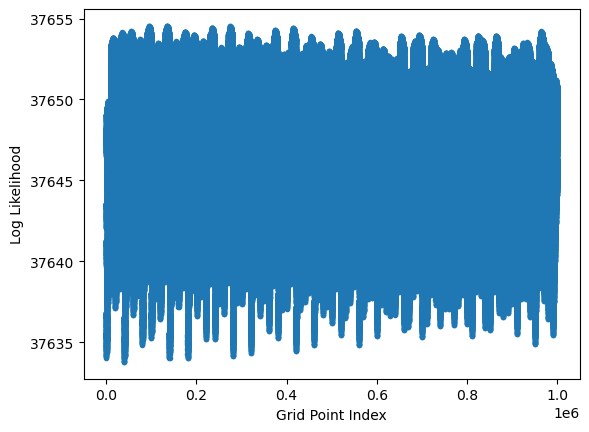

: 

In [ ]:
# Plot the lnL oscillations as it steps through iteration of the grid

plt.plot(logls, ls="", marker=".")
plt.ylabel("Log Likelihood")
plt.xlabel("Grid Point Index")

Above isn't that intuitive except that it appears to have clear flanged oscillations as the signal phase wraps.

Below we look at a 3D representation instead

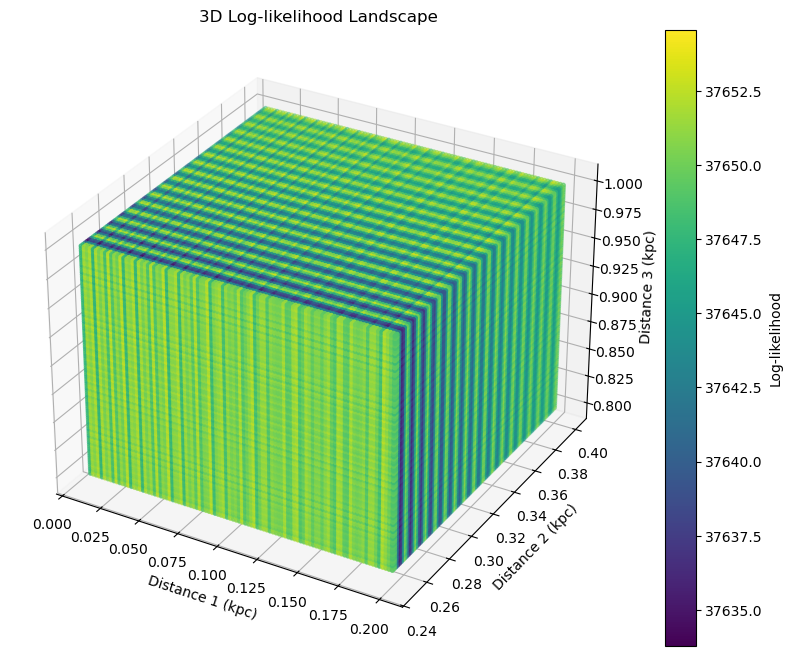

: 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Flatten everything
D1f = D1.ravel()
D2f = D2.ravel()
D3f = D3.ravel()
LNLf = logls.ravel()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(D1f, D2f, D3f, c=LNLf, cmap='viridis', s=8)
fig.colorbar(p, ax=ax, label='Log-likelihood')

ax.set_xlabel("Distance 1 (kpc)")
ax.set_ylabel("Distance 2 (kpc)")
ax.set_zlabel("Distance 3 (kpc)")
ax.set_title("3D Log-likelihood Landscape")

plt.show()

The scale of the oscillation is much more obvious. 

But it's more useful to actually understand the structure of the oscillation "given" one of the changing parameters I think.

So let's take a slice of one of the pular distances which is the closest to its true value.

AttributeError: 'list' object has no attribute 'reshape'

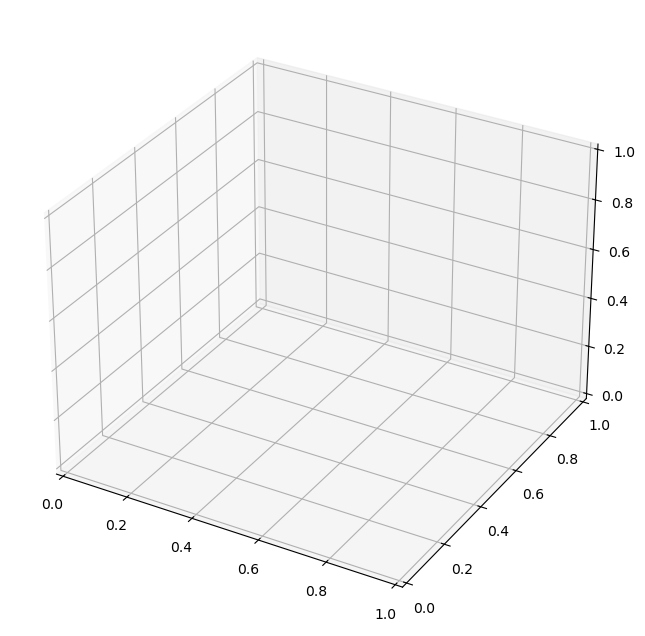

: 

In [ ]:


idx = jnp.searchsorted(distance2, enterprise_params['J0030+0451_cw_p_dist'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use meshgrid for the 2D plane
D1, D3 = jnp.meshgrid(distance1, distance3, indexing='ij')

# Plot the surface
surf = ax.plot_surface(D1, D3, logls.reshape(len(distance1), len(distance2), len(distance3))[:, idx, :],
                       cmap='viridis', linewidth=0, antialiased=False)

ax.plot(enterprise_params['J0437-4715_cw_p_dist'], enterprise_params['J0125-2327_cw_p_dist'], 
         marker='x', color='red', markersize=10, label='Injected Value')

ax.set_xlabel("Distance 1 (kpc)")
ax.set_ylabel("Distance 3(kpc)")
ax.set_zlabel("Log-likelihood")
ax.set_title(f"Log-likelihood surface (Distance 2 = {distance2[idx]:.2f} kpc)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()


Text(0, 0.5, 'Distance 2 variation (kpc)')

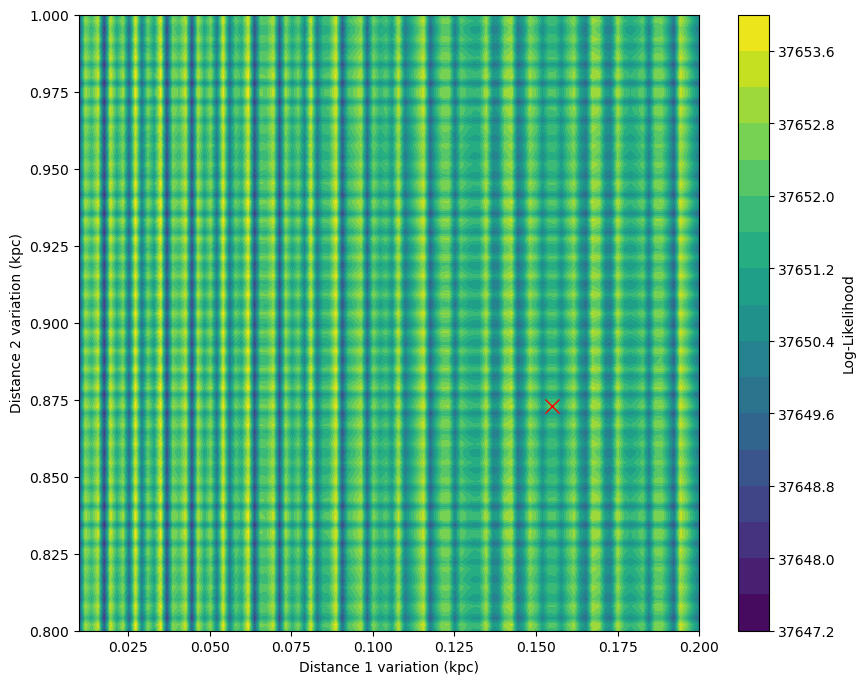

: 

In [ ]:
plt.figure(figsize=(10, 8))
plt.contourf(D1, D3, logls.reshape(len(distance1), len(distance2), len(distance3))[:, idx, :], levels=20, cmap='viridis')
plt.plot(enterprise_params['J0437-4715_cw_p_dist'], enterprise_params['J0125-2327_cw_p_dist'], marker='x', color='red', markersize=10, label='Injected Value')
plt.colorbar(label='Log-Likelihood')
plt.xlabel("Distance 1 variation (kpc)")
plt.ylabel("Distance 2 variation (kpc)")

This is much more intuitive! Looks exactly like we thought it would! 

It shows the rapid oscillation of the lnL, and especially that the pulsar distance is in a lnL peak across these extreme oscillations.

#### Hessian check

Next we want to try and look at the hessian.

In [ ]:
# Grab the injected values as a truth check
truths = {}
truths.update({p: sorted_dict[p] for p in logl.params })

: 

In [ ]:
# Reorder the dictionary again out of absolute paranoia
order_map = {key: i for i, key in enumerate(logl.params)}
sorted_items = sorted(truths.items(), key=lambda item: order_map.get(item[0], float('inf')))
sorted_dict = dict(sorted_items)


: 

sorted_dict now holds the true injected values that we want to test the Hessian on

In [ ]:
# Grab a jnp vector array out of the sorted dict and define jitted functions

x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
logl_fn = jax.jit(logl_wrapped)
grad_fn = jax.jit(jax.grad(logl_fn))
hess_fn = jax.jit(jax.hessian(logl_fn))

: 

In [ ]:
# Try the lnL again to be safe
print("logl_fn: {}".format(logl_fn(x0)))

logl_fn: 37645.15663396609


: 

In [ ]:
# Calc and check the gradient
G = grad_fn(x0)


: 

In [ ]:
G

Array([ 7.77316013e+02, -5.50748285e-01, -5.16305472e-01, -8.55963113e+02,
       -9.72618152e-03, -3.90104127e-02,  8.48936069e+03,  1.56706737e-02,
        4.35354399e-02,  9.67152637e+01, -2.32727277e-05, -5.04598903e-05,
        3.91052315e+03,  1.55324036e-03,  4.37056438e-03, -2.99450029e+01,
       -2.27609541e-04, -8.00255025e-04,  3.58772990e+03, -1.47816791e-01,
       -2.84527276e-01, -7.99478192e+02, -1.59357128e-05, -4.15636812e-05,
       -9.75004668e+01, -1.14113207e-05, -3.04115120e-05,  2.92339280e+02,
       -3.03937001e-01, -5.64075396e-01, -1.10583120e+01, -5.86232501e+00,
        9.92987488e+04,  8.79620243e+03, -1.85315139e+01, -1.49438192e+01,
       -6.33468272e+00, -5.07317530e+00, -3.36042186e+00, -9.84066077e+00,
        4.39757222e+04, -2.70087165e+03, -1.52048570e+04, -4.54568638e+03,
       -2.13631253e+01, -2.08467381e+01], dtype=float64)

: 

In [ ]:
# Calc and check the Hessian
H = hess_fn(x0)

: 

In [ ]:
H

Array([[ 9.14001952e+07,  9.03778703e+01,  1.74386696e+02, ...,
        -6.37406388e+06,  4.18267150e+02,  1.08976196e+03],
       [ 9.03778703e+01, -1.70464149e+00, -2.27143576e+00, ...,
        -9.47931578e+00, -7.79081962e-01, -2.04951714e+00],
       [ 1.74386696e+02, -2.27143576e+00, -2.30354145e+00, ...,
        -2.08363359e+01, -2.05251409e+00, -5.06367937e+00],
       ...,
       [-6.37406388e+06, -9.47931578e+00, -2.08363359e+01, ...,
        -1.00101994e+09,  1.71386471e+03,  3.80444255e+03],
       [ 4.18267150e+02, -7.79081962e-01, -2.05251409e+00, ...,
         1.71386471e+03, -3.41270144e+01, -6.02541698e+01],
       [ 1.08976196e+03, -2.04951714e+00, -5.06367937e+00, ...,
         3.80444255e+03, -6.02541698e+01, -9.89698326e+01]],      dtype=float64)

: 

In [ ]:
# Check out the condition number of the Hessian
jnp.linalg.cond(H)

Array(5.3604881e+15, dtype=float64)

: 

That's not good! But otherwise the lnL evaluation looks like it's working well.